### Imports

In [1]:
import os
import sys
import random

In [2]:
import numpy as np

In [3]:
import torch
from torch.utils.data import Dataset

In [4]:
import torchvision
import torchvision.transforms as transforms

In [5]:
from torchvision.transforms import InterpolationMode

In [6]:
# our library
from svetlanna import SimulationParameters
from svetlanna import elements
from svetlanna import Wavefront

In [7]:
# datasets of wavefronts
from src.wf_transforms import ToWavefront
from src.wf_datasets import WavefrontsDatasetSimple, WavefrontsDatasetWithSLM
from src.wf_datasets import DatasetOfWavefronts

In [8]:
import matplotlib.pyplot as plt

plt.style.use('dark_background')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# 1. Raw [MNIST Dataset](https://www.kaggle.com/datasets/hojjatk/mnist-dataset)

Load a dataset from `torchvision` in the selected directory and create train and test datasets.

In [9]:
# initialize a directory for a dataset
data_filepath = './data'  # folder to store data

In [10]:
import ssl
# to solve the problem with cerificates while downloading a dataset using torchvision
# solution from: https://github.com/pytorch/pytorch/issues/33288#issuecomment-954160699
ssl._create_default_https_context = ssl._create_unverified_context

## 1.1. Train dataset

In [11]:
mnist_train_ds = torchvision.datasets.MNIST(
    root=data_filepath,
    train=True,  # for train dataset
    download=True,
    # transform=transforms.ToTensor()  # <- transforms images to tensors
)

len(mnist_train_ds)

60000

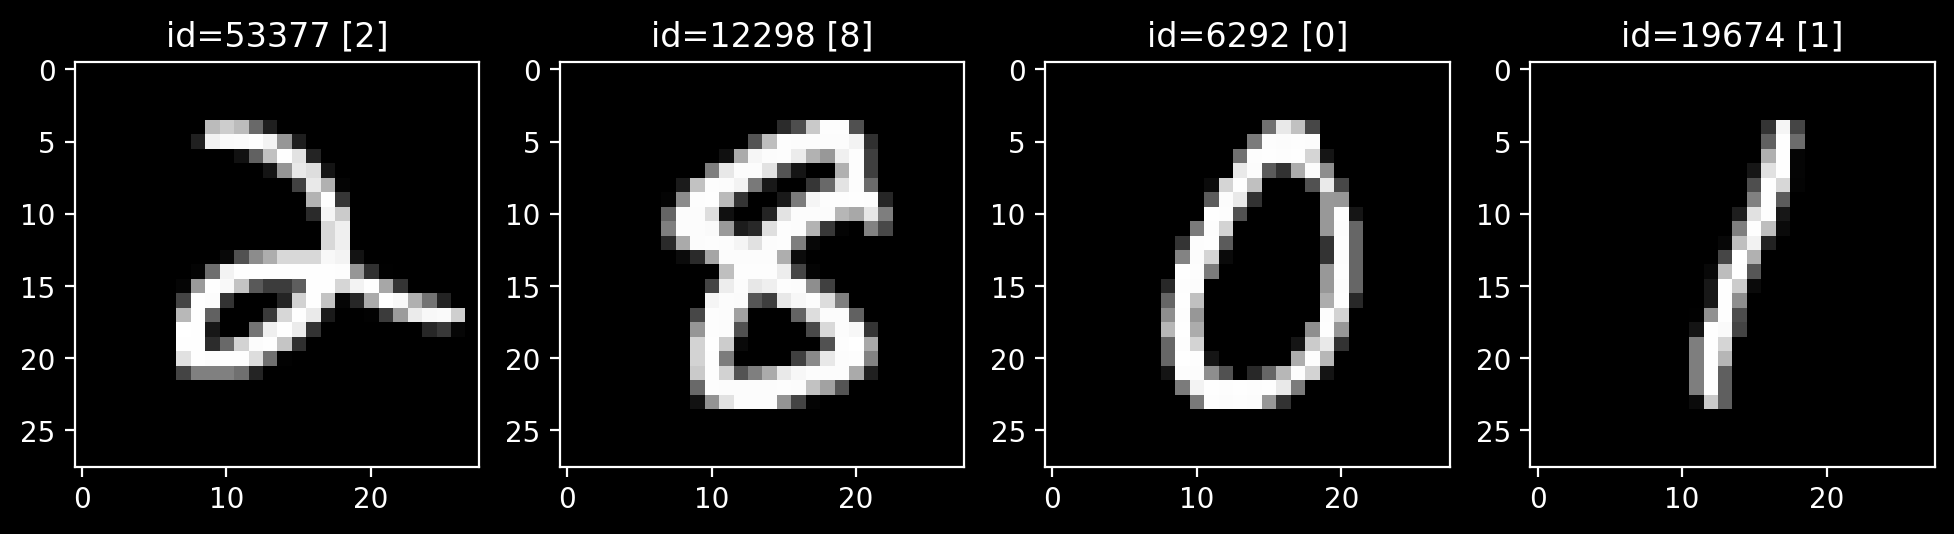

In [12]:
# plot several images
n_examples= 4  # number of examples to plot

# choosing indecies of images (from train) to plot
random.seed(78)
train_examples_ids = random.sample(range(len(mnist_train_ds)), n_examples)

fig, axs = plt.subplots(1, n_examples, figsize=(n_examples * 3, 3))
for ind_ex, ind_train in enumerate(train_examples_ids):
    image, target = mnist_train_ds[ind_train]

    axs[ind_ex].set_title(f'id={ind_train} [{target}]')
    axs[ind_ex].imshow(image, cmap='gray')

plt.show()

Each image is of the size `torch.Size([1, 28, 28])`

## 1.2. Types for dataset

In [13]:
# what is a type of the objects?
type(mnist_train_ds)

torchvision.datasets.mnist.MNIST

In [14]:
# check if created object is an instance of class Dataset
assert isinstance(mnist_train_ds, Dataset)

# 2. Datasets of wavefronts

In [15]:
# simulation parameters for examples
x_nodes = 100
y_nodes = x_nodes

x_size = 20 * 1e-2  # [m]
y_size = x_size  # [m]

wavelength = 1000 * 1e-9  # [m]

In [16]:
sim_params = SimulationParameters(
    x_size=x_size,  # [m]
    y_size=y_size,  # [m]
    x_nodes=x_nodes,
    y_nodes=y_nodes,
    wavelength=wavelength  # [m]
)

## 2.1. Wavefronts dataset class obtained with SLM

In [17]:
WavefrontsDatasetWithSLM?

Init signature:
WavefrontsDatasetWithSLM(
    images_ds: torch.utils.data.dataset.Dataset,
    image_transforms_comp: torchvision.transforms.transforms.Compose,
    sim_params: svetlanna.simulation_parameters.SimulationParameters,
    beam_field: torch.Tensor,
    system_before_slm: list,
    slm_levels: int = 256,
)
Docstring:     
Dataset of wavefronts for a classification task for an optical network.
    Each raw image is used as a mask for SLM, that illuminated by a some beam field.
    A resulted wavefront will be an input tensor for an optical network.
Init docstring:
Parameters
----------
images_ds : torch.utils.data.Dataset
    A dataset of raw images and classes labels.
image_transforms_comp : transforms.Compose
    A sequence of transforms that will be applied to an image before its convertation to an SLM mask.
sim_params : SimulationParameters
    Simulation parameters for a further optical network.
beam_field : torch.Tensor
    A field of a beam (result of Beam.forward) tha

### 2.1.2. Parameters for a dataset of wavefronts (with SLM)

In [18]:
# generation of a beam wavefront, using new Wavefront class: 
prop_distance = 0  # [m]

beam_wavefront = Wavefront.gaussian_beam(
    simulation_parameters=sim_params,
    waist_radius=5 * 1e-2,  # [m]
    distance=prop_distance,  # [m]
)

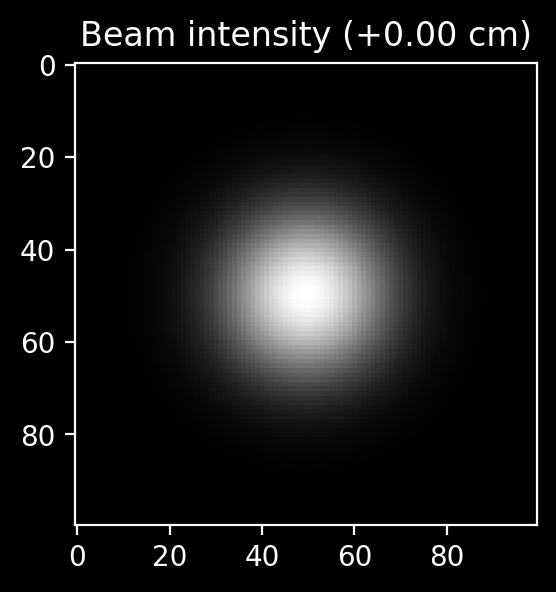

In [19]:
# let's take a look at a beam intensity distribution
fig, ax0 = plt.subplots(1, 1, figsize=(3, 3))

ax0.set_title(f'Beam intensity (+{prop_distance * 100:.2f} cm)')
ax0.imshow(beam_wavefront.intensity, cmap='gray')

plt.show()

In [20]:
# specify system before slm for a further dataset of wavefronts
free_space_1 = elements.FreeSpace(
    simulation_parameters=sim_params,
    distance=1 * 1e-2,  # [m]
    method='AS'
)

system_before_slm = [
    free_space_1
]

## 2.1.2 Train and Test datasets of wavefronts

In [21]:
image_transform_for_ds = transforms.Compose(
  [
      transforms.ToTensor(),
      transforms.Resize(
          size=(y_nodes, x_nodes),
          interpolation=InterpolationMode.NEAREST,
      ),
  ]  
)

In [22]:
# train dataset
mnist_wf_train_ds = WavefrontsDatasetWithSLM(
    images_ds=mnist_train_ds,  # dataset of images
    image_transforms_comp=image_transform_for_ds,  # image transformation
    sim_params=sim_params,  # simulation parameters
    beam_field=beam_wavefront,
    system_before_slm=system_before_slm,
    slm_levels=256
)

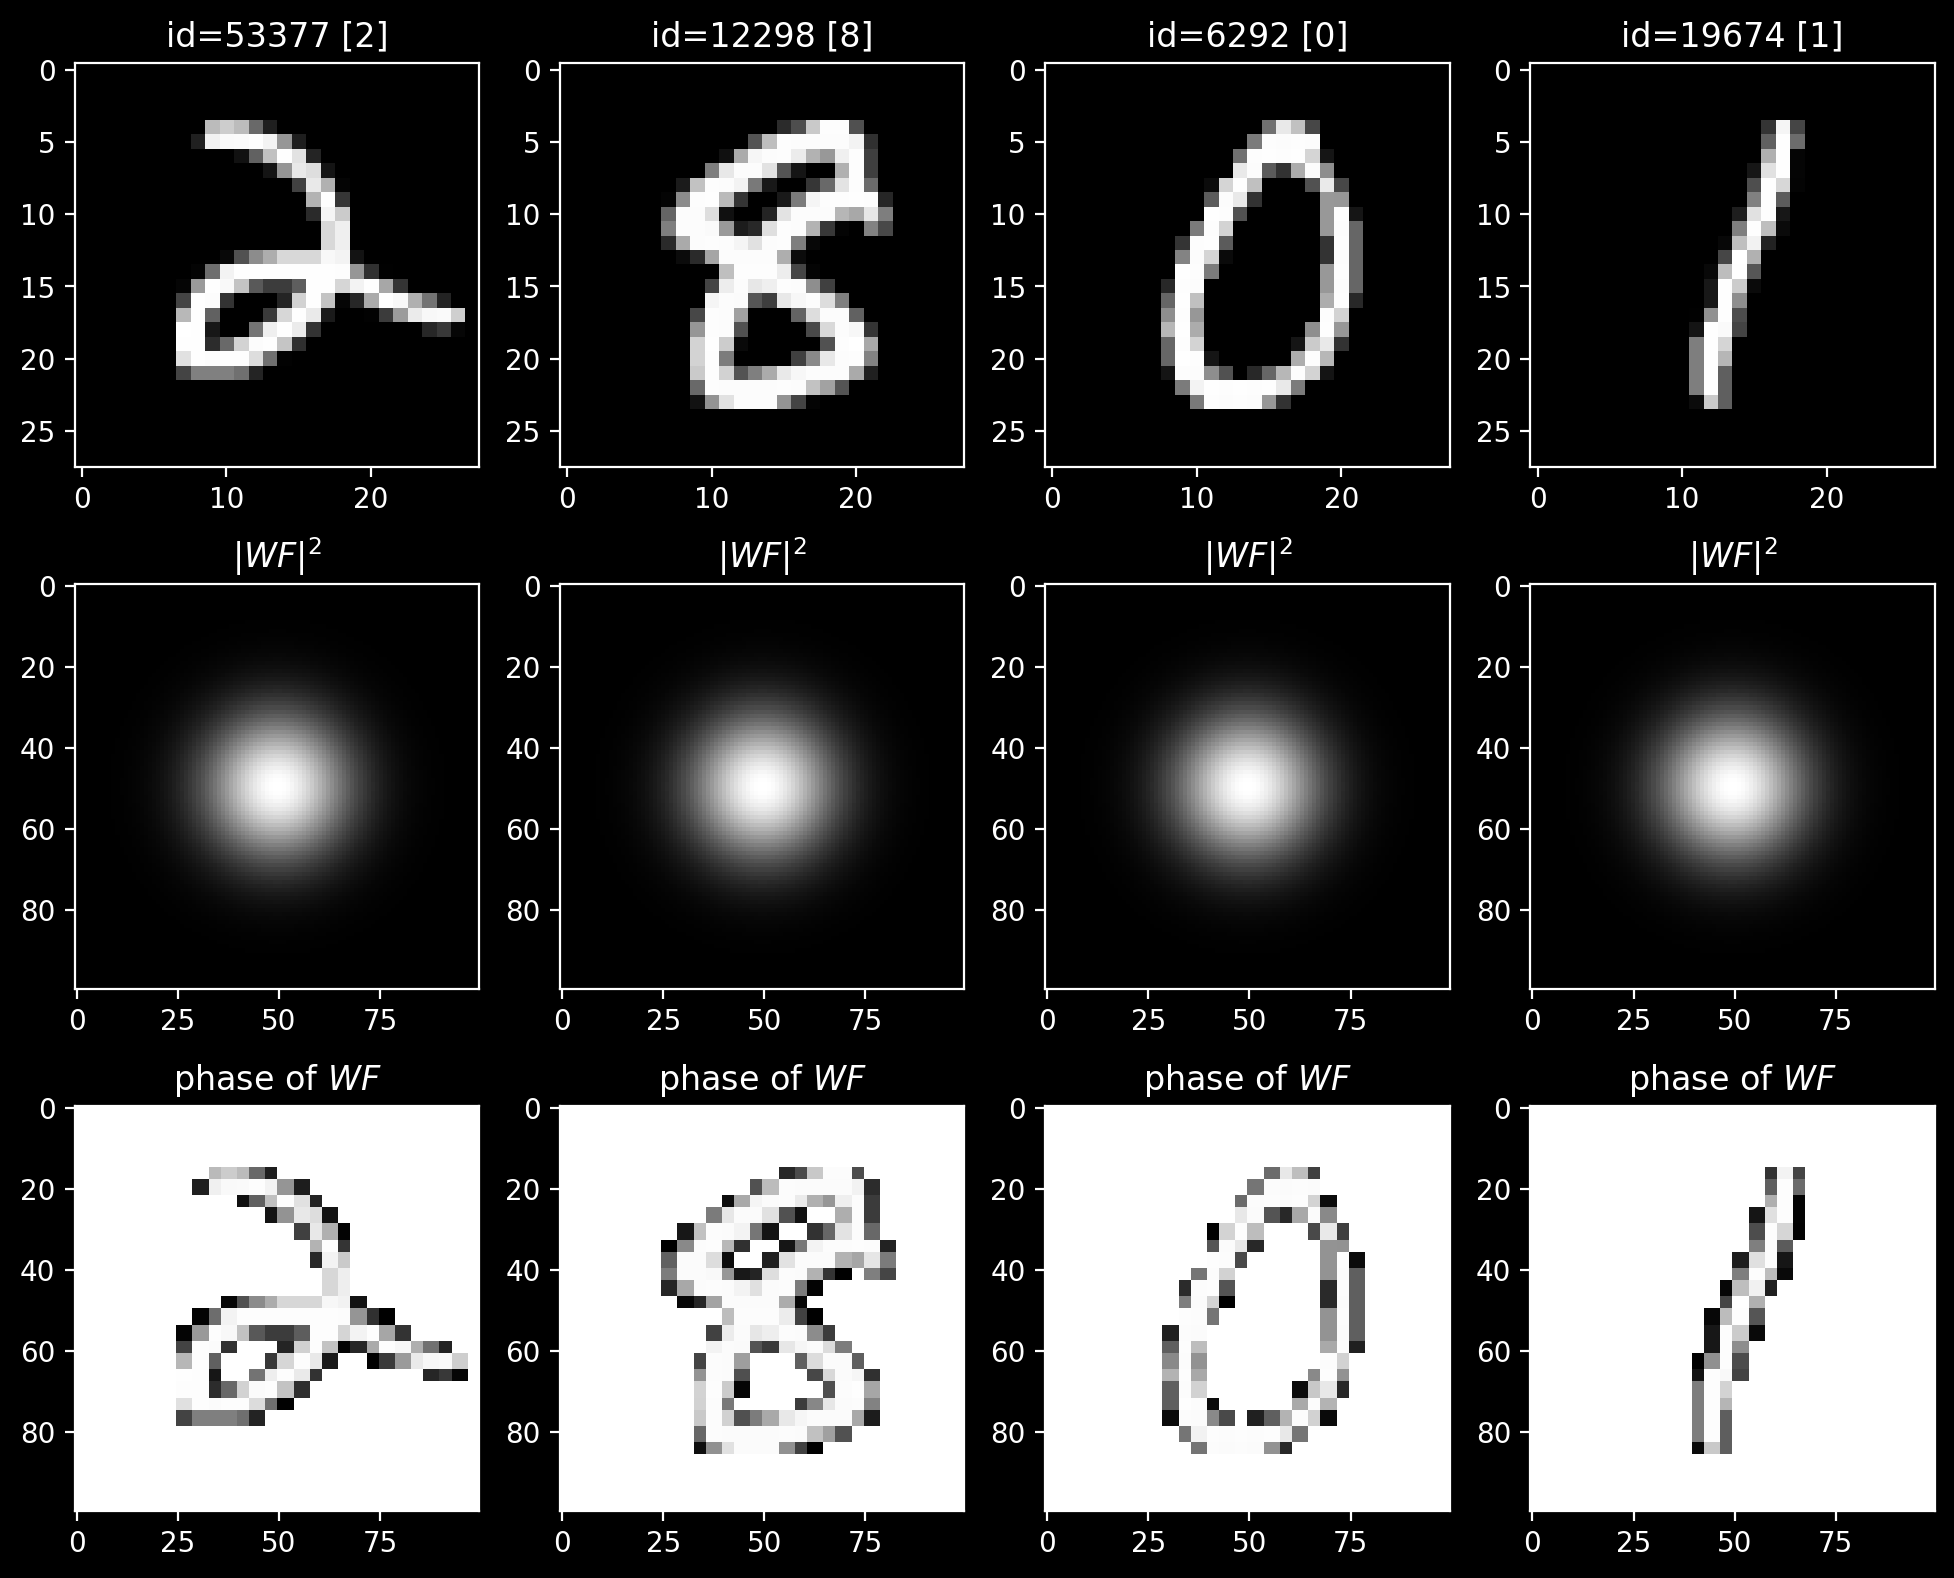

In [23]:
# plot example images
n_lines = 3
fig, axs = plt.subplots(n_lines, n_examples, figsize=(n_examples * 3, n_lines * 3.2))

for ind_ex, ind_train in enumerate(train_examples_ids):
    image, label = mnist_train_ds[ind_train]
    
    axs[0][ind_ex].set_title(f'id={ind_train} [{label}]')
    axs[0][ind_ex].imshow(image, cmap='gray')

    wavefront, wf_label = mnist_wf_train_ds[ind_train]
    assert isinstance(wavefront, Wavefront)

    axs[1][ind_ex].set_title(f'$|WF|^2$')
    # here we can plot intensity for a wavefront
    axs[1][ind_ex].imshow(wavefront.intensity[0], cmap='gray')
    
    axs[2][ind_ex].set_title(f'phase of $WF$')
    axs[2][ind_ex].imshow(wavefront.phase[0], cmap='gray')

plt.show()

In [24]:
print(f'Train wf data: {len(mnist_wf_train_ds)}')

Train wf data: 60000


## 2.2. Wavefronts dataset class (an image as an amplitude and/or a phase)

In [25]:
WavefrontsDatasetSimple?

Init signature:
WavefrontsDatasetSimple(
    images_ds: torch.utils.data.dataset.Dataset,
    image_transforms_comp: torchvision.transforms.transforms.Compose,
    sim_params: svetlanna.simulation_parameters.SimulationParameters,
)
Docstring:     
Dataset of wavefronts for a classification task for an optical network.
    Each raw image is encoded in the amplitude and/or phase.
Init docstring:
Parameters
----------
images_ds : torch.utils.data.Dataset
    A dataset of raw images and classes labels.
image_transforms_comp : transforms.Compose
    A sequence of transforms that will be applied to an image before its convertation to an SLM mask.
sim_params : SimulationParameters
    Simulation parameters for a further optical network.
File:           ~/science-phd/git-projects/SVETlANNa/examples/pipeline/src/wf_datasets.py
Type:           type
Subclasses:     

### 2.2.1 Each image can be encoded as an amplitude and phase distribution

In [26]:
image_transform_for_ds = transforms.Compose(
  [
      transforms.ToTensor(),
      transforms.Resize(
          size=(int(y_nodes / 2), int(x_nodes / 2)),
          interpolation=InterpolationMode.NEAREST,
      ),
  ]  
)

In [27]:
# train dataset
mnist_wf02_train_ds = WavefrontsDatasetSimple(
    images_ds=mnist_train_ds,  # dataset of images
    image_transforms_comp=image_transform_for_ds,  # image transformation
    sim_params=sim_params,  # simulation parameters
)

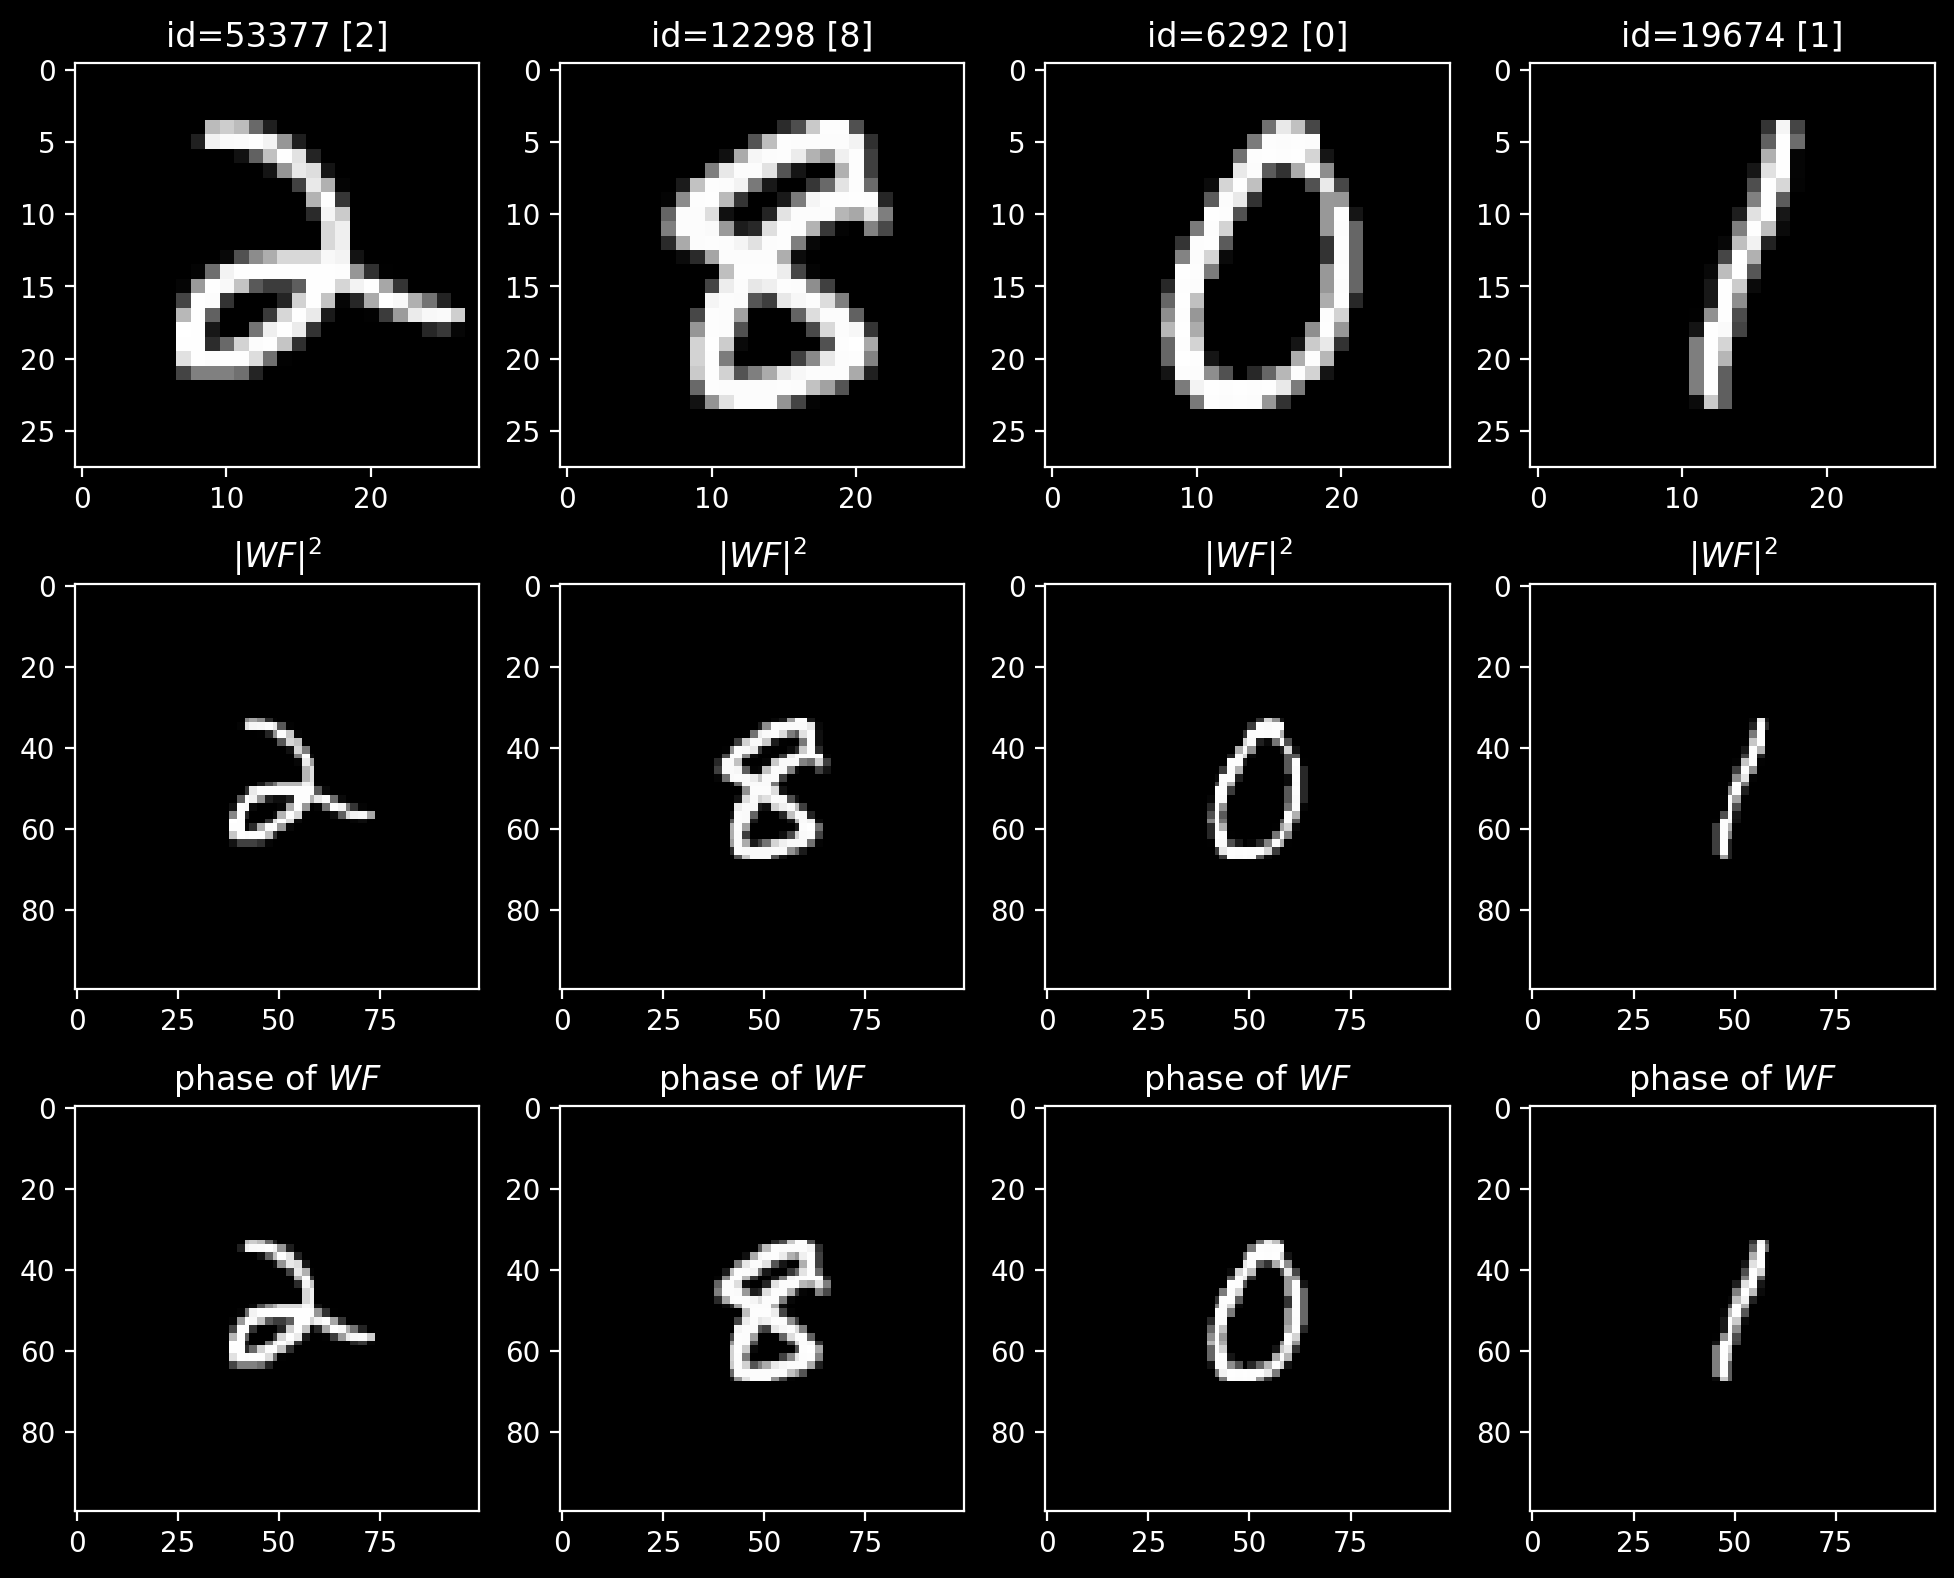

In [28]:
# plot example images
fig, axs = plt.subplots(n_lines, n_examples, figsize=(n_examples * 3, n_lines * 3.2))

for ind_ex, ind_train in enumerate(train_examples_ids):
    image, label = mnist_train_ds[ind_train]
    
    axs[0][ind_ex].set_title(f'id={ind_train} [{label}]')
    axs[0][ind_ex].imshow(image, cmap='gray')

    wavefront, wf_label = mnist_wf02_train_ds[ind_train]
    assert isinstance(wavefront, Wavefront)

    axs[1][ind_ex].set_title(f'$|WF|^2$')
    # here we can plot intensity for a wavefront
    axs[1][ind_ex].imshow(wavefront.intensity[0], cmap='gray')
    
    axs[2][ind_ex].set_title(f'phase of $WF$')
    axs[2][ind_ex].imshow(wavefront.phase[0], cmap='gray')

plt.show()

## 2.3. Wavefronts dataset class using only `transforms.Compose`

In [29]:
resize_y = int(y_nodes / 2)
resize_x = int(x_nodes / 2)  # shape for transforms.Resize

pad_top = int((y_nodes - resize_y) / 2)
pad_bottom = y_nodes - pad_top - resize_y
pad_left = int((x_nodes - resize_x) / 2)
pad_right = x_nodes - pad_left - resize_x  # params for transforms.Pad


image_transform_for_ds03 = transforms.Compose(
  [
      transforms.ToTensor(),
      transforms.Resize(
          size=(resize_y, resize_x),
          interpolation=InterpolationMode.NEAREST,
      ),
      transforms.Pad(
          padding=(
              pad_left,  # left padding
              pad_top,  # top padding
              pad_right,  # right padding
              pad_bottom  # bottom padding
          ),
          fill=0,
      ),  # padding to match sizes!
      ToWavefront(modulation_type='phase')  # <- select modulation type!
  ]  
)

In [30]:
# check warnings
image_transform_for_ds_check = transforms.Compose(
  [
      transforms.ToTensor(),
      transforms.Resize(
          size=(resize_y, resize_x),
          interpolation=InterpolationMode.NEAREST,
      ),
  ]  
)

mnist_wf_train_ds_check = DatasetOfWavefronts(
    init_ds=mnist_train_ds,  # dataset of images
    transformations=image_transform_for_ds_check,  # image transformation
    sim_params=sim_params
)

/Users/giyuu/science-phd/git-projects/SVETlANNa/examples/pipeline/src/wf_datasets.py:47: UserWarning: An output object is not of the Wavefront type!
  warnings.warn(
/Users/giyuu/science-phd/git-projects/SVETlANNa/examples/pipeline/src/wf_datasets.py:54: UserWarning: A shape of a resulted Wavefront does not match with SimulationParameters!
  warnings.warn(


In [31]:
# train dataset
mnist_wf_train_ds03 = DatasetOfWavefronts(
    init_ds=mnist_train_ds,  # dataset of images
    transformations=image_transform_for_ds03,  # image transformation
    sim_params=sim_params
)

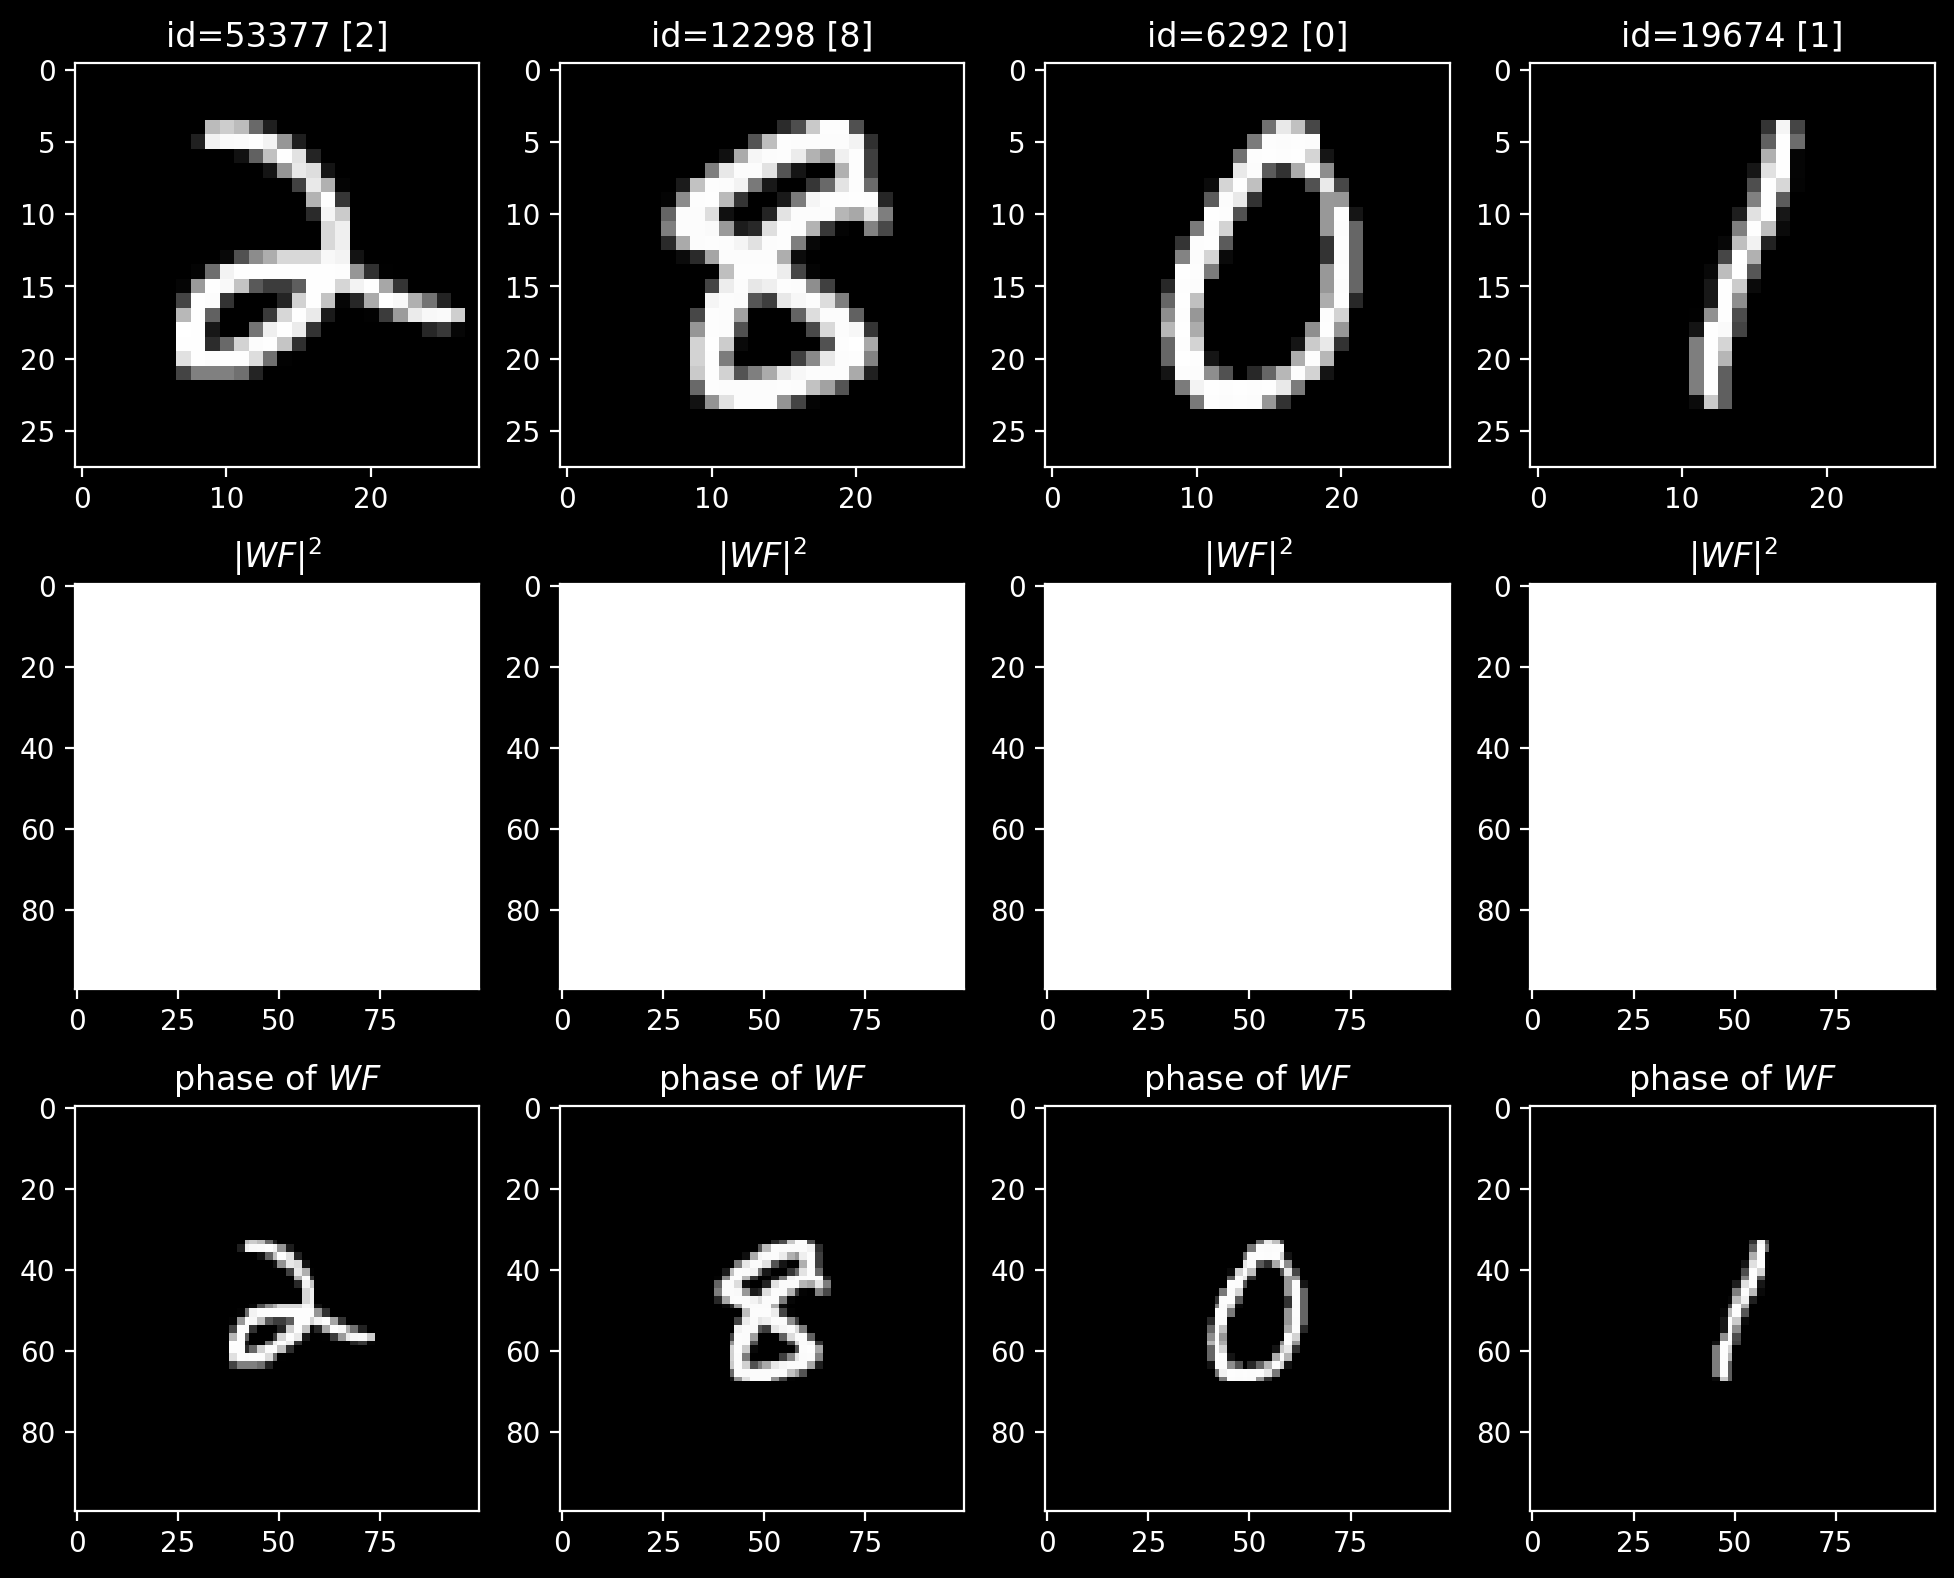

In [38]:
# plot example images
fig, axs = plt.subplots(n_lines, n_examples, figsize=(n_examples * 3, n_lines * 3.2))

for ind_ex, ind_train in enumerate(train_examples_ids):
    image, label = mnist_train_ds[ind_train]
    
    axs[0][ind_ex].set_title(f'id={ind_train} [{label}]')
    axs[0][ind_ex].imshow(image, cmap='gray')

    wavefront, wf_label = mnist_wf_train_ds03[ind_train]
    assert isinstance(wavefront, Wavefront)

    axs[1][ind_ex].set_title(f'$|WF|^2$')
    # here we can plot intensity for a wavefront
    axs[1][ind_ex].imshow(
        wavefront.intensity[0], cmap='gray',
        vmin=0, vmax=1,
    )
    
    axs[2][ind_ex].set_title(f'phase of $WF$')
    axs[2][ind_ex].imshow(
        wavefront.phase[0], cmap='gray',
        vmin=0, vmax=2 * torch.pi
    )

plt.show()